# 🔊 AUDIO: Understanding and Generating Speech

## First, we need to install miniconda and Python 3.11
### Why are we installing Miniconda and Python 3.11?

Google Colab currently runs on **Python 3.12**.

The **Coqui TTS (XTTS v2)** library we’re using **does not support Python 3.12** yet – it works only up to **Python 3.11** because some of its dependencies are not updated for 3.12.

To solve this, we:

1. Install **Miniconda** inside Colab  
2. Use it to install **Python 3.11** in a separate environment  
3. Run Coqui TTS from that environment

You don’t need to worry about the details – just remember:

> We install Miniconda + Python 3.11 because Colab’s default Python 3.12 is too new for Coqui TTS.


In [ ]:
%%bash
set -e  # stop on error

echo "Installing Miniconda..."
wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh >/dev/null 2>&1
bash miniconda.sh -b -p /usr/local/miniconda >/dev/null 2>&1
rm miniconda.sh

echo "Accepting TOS..."
/usr/local/miniconda/bin/conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main >/dev/null 2>&1
/usr/local/miniconda/bin/conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r >/dev/null 2>&1

echo "Installing Python 3.11..."
/usr/local/miniconda/bin/conda install python=3.11 -y >/dev/null 2>&1

echo "Initializing conda..."
source /usr/local/miniconda/etc/profile.d/conda.sh >/dev/null 2>&1
conda activate base >/dev/null 2>&1

echo "Python version:"
python --version


Installing Miniconda...
Accepting TOS...
Installing Python 3.11...
Initializing conda...
Python version:
Python 3.11.14


### Updating the Python executable inside this Colab notebook

Even though we installed Python 3.11 using Miniconda,  
the Colab **Python kernel** still uses its own default interpreter (Python 3.12).

To make sure that the notebook actually runs the new Python 3.11 environment,
we update the `PATH` variable inside Python so that Colab uses Miniconda’s Python.


In [ ]:
import os
import sys

os.environ["PATH"] = "/usr/local/miniconda/bin:" + os.environ["PATH"]
print("Executable:", sys.executable)
!python --version

Executable: /usr/bin/python3
Python 3.11.14


### Downloading the project assets

We clone the repository because all additional files we need for the demo  
(such as audio samples, WAV files, and other assets) are stored inside it.

By running:

`!git clone https://github.com/pfe-rs/psiml-applied-ai.git`

we download the full folder structure that contains:
- example speaker WAV files
- notebooks
- helper scripts
- assets used in the exercises

This makes it easy to use the provided audio files directly in our TTS examples.


In [ ]:
!git clone https://github.com/pfe-rs/psiml-applied-ai.git
sys.path.append("/content/psiml-applied-ai/notebooks")



Cloning into 'psiml-applied-ai'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 102 (delta 46), reused 75 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 10.04 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (46/46), done.


**Speech-To-Speech translation (STST or S2ST)** enables speakers in different languages to communicate with one another relatively easy.

We are going to solve this problem via a **cascaded approach** that will consist of the following components:
- *Automatic Speech Recognition (ASR)*: a way to transcribe the source speech into the text
- *Machine Translation (MT)*: text translation from the source language to the target language
- *Text-to-Speech (TTS)* to generate speech in the target language from the translated text

This approach can be visualized:

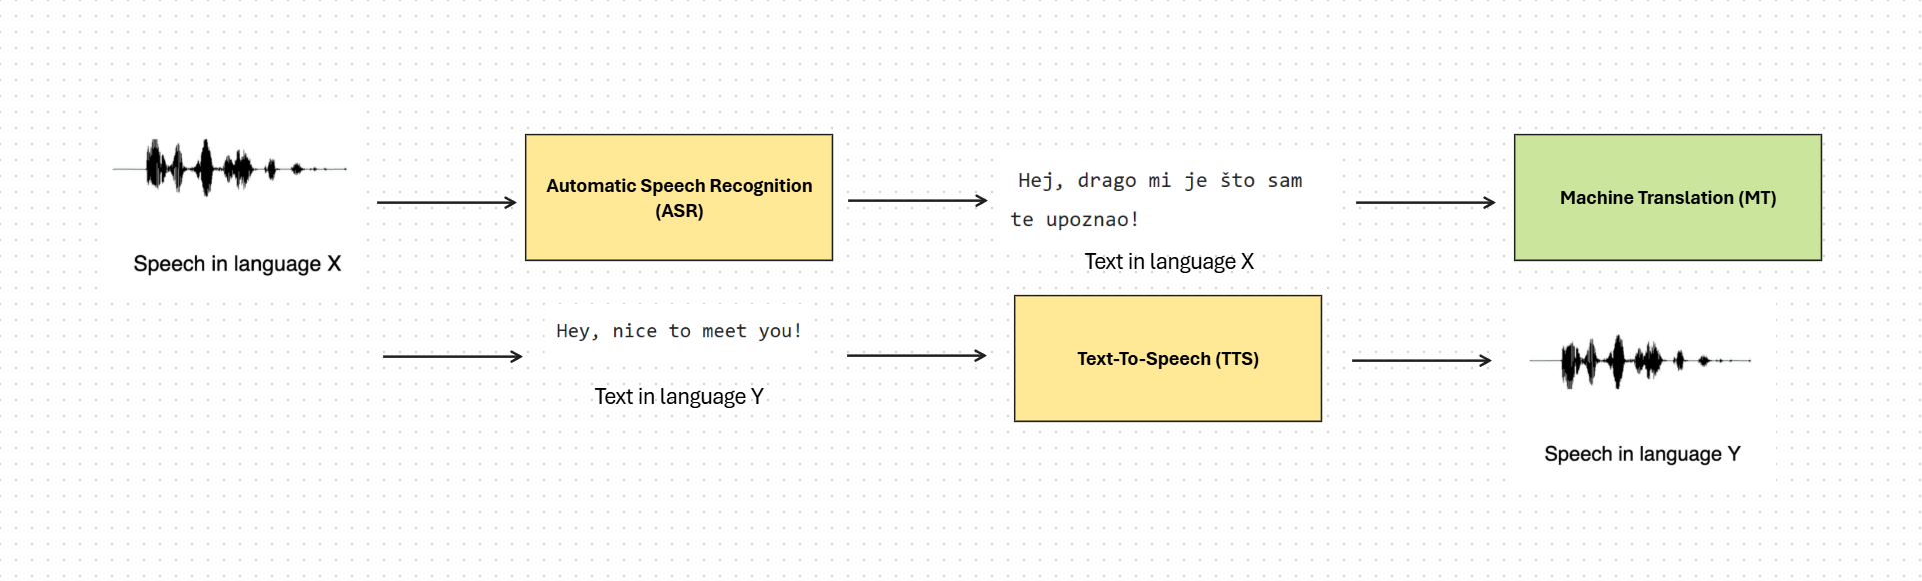

In [ ]:
from IPython.display import Image
Image(filename="psiml-applied-ai/notebooks/attachments/Speech-To-Speech-Cascaded-Pipeline.png", width=1600)

See a detailed [HuggingFace blogpost](https://huggingface.co/learn/audio-course/chapter7/speech-to-speech) about the S2ST problem.

### Installing the correct library versions for XTTS v2

XTTS v2 depends on specific versions of several Python packages.  
Newer versions (especially of **NumPy**, **Transformers**, and **Tokenizers**) introduce breaking changes that cause XTTS to fail during import or during inference.

Because Colab frequently updates its default libraries, we manually install versions that are known to work reliably with XTTS v2:

- `numpy < 2.0` – XTTS is not compatible with NumPy 2.x  
- `transformers 4.37.2` and `tokenizers 0.15.2` – newer releases remove APIs used by XTTS  
- `TTS 0.22.0` – the last stable XTTS version before major breaking changes  
- `torchcodec` – required for loading and decoding audio inputs  
- `ffmpeg` – required for handling audio formats

This ensures a clean and stable environment for running XTTS inference inside Google Colab.


In [ ]:
%%bash
# Correct, stable versions for XTTS v2:
pip install --upgrade --force-reinstall "numpy<2.0.0"
pip install --upgrade --force-reinstall transformers==4.37.2 tokenizers==0.15.2
pip install TTS==0.22.0
pip install torchcodec
apt -qq -y install ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 20.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 96.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 35.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.4/800.4 kB 32.4 MB/s  0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
  Attempting uninstall: tqdm
    Foun

  DEPRECATION: Building 'gruut' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'gruut'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'gruut-ipa' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'gruut-ipa'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'gruut_lang_de' using the legacy setup.py bdist_wheel mechan

### Checking PyTorch and selecting the device

Here we verify that PyTorch is installed correctly and detect whether a GPU
is available in the Colab runtime.  
If a CUDA-enabled GPU is present, we use it for XTTS (much faster).  
Otherwise, the code falls back to CPU.

This ensures that the TTS model always runs on the best available hardware.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from scripts.helpers import ensure_wav_16k_mono

def convert_to_wav(ind: int):
    in_path = ds.iloc[ind]["audio_path"]
    out_16k_path = f"/content/psiml-applied-ai/notebooks/wavs/audio_{ind}.wav"
    ensure_wav_16k_mono(in_path, out_16k_path)

## What data will we use?

**Common Voice (Mozilla)**: an open-source voice dataset for building speech-enabled applications.

See https://commonvoice.mozilla.org/en/datasets for details.

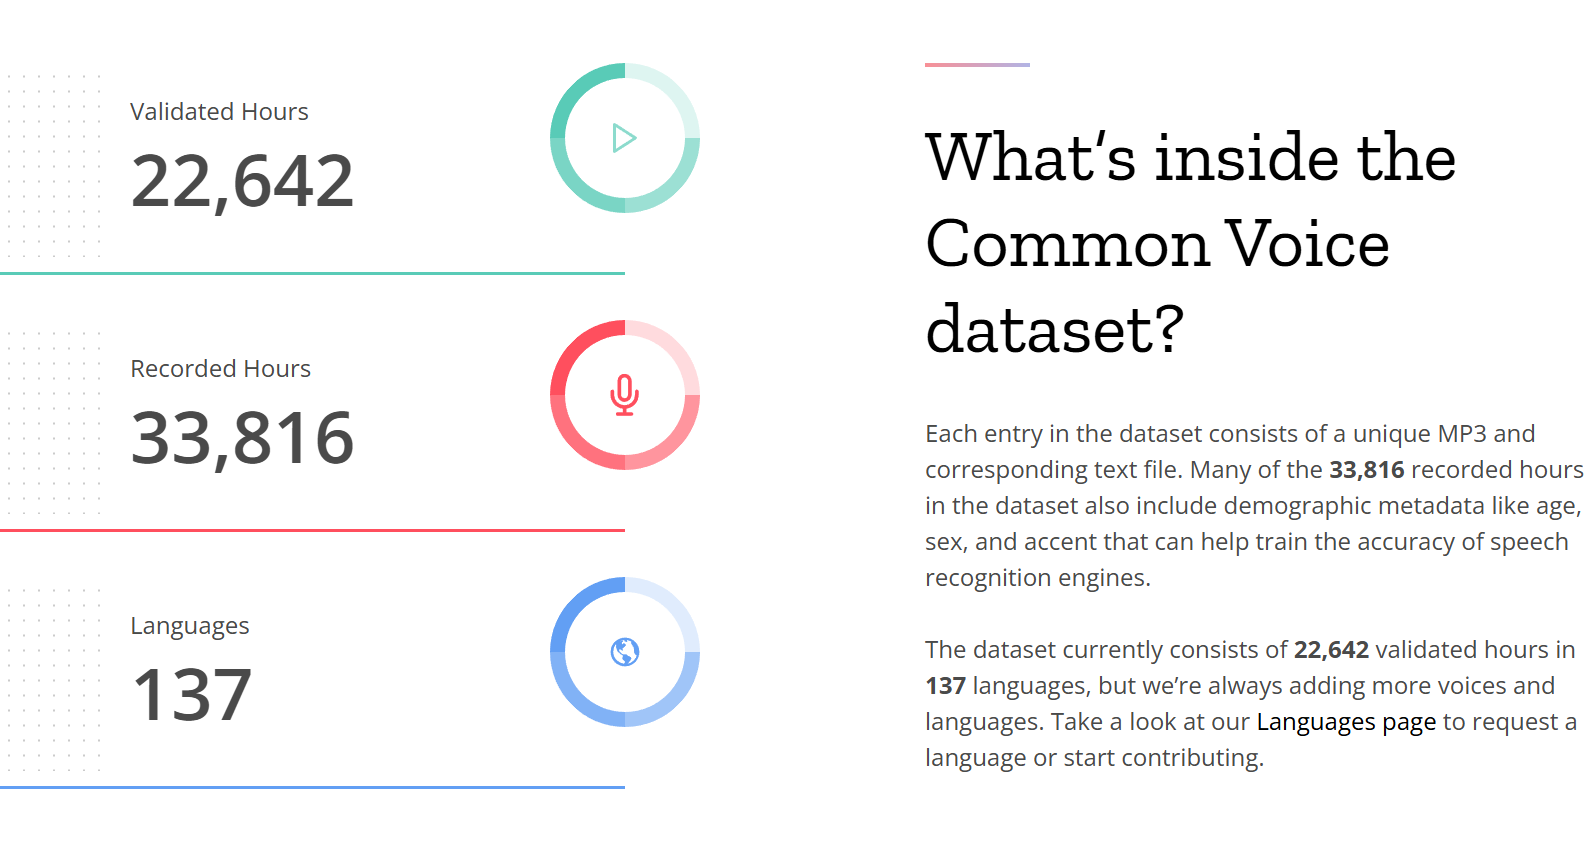

In [ ]:
Image(filename="/content/psiml-applied-ai/notebooks/attachments/Common-Voice-Stats.png", width=800)

## How to load audio samples

To process audio properly one needs to know the following audio parameters:
- *Sample rate (Hz)*. Higher sample rates capture more detail, but increase file size and computation.
- *Number of channels*: mono, stereo, multichannel.
- *Bit depth*. Number of bits used to represent each sample (commonly 8-bit / 16-bit / 24-bit / 32-bit float).

For the sake of simplicity, in this demo we use standartized 16 kHz mono-channeled WAV's from the Common Voice dataset.

Download the following subset of the CommonVoice for Serbian dataset and put its contents to `/content/common_voice_sr`:

In [ ]:
# Download Mozilla Common Voice from the official website and put its contents to `/content/common_voice_sr`
!curl -L -o common_voice_sr.zip "https://drive.google.com/uc?export=download&id=1xcexfLwVK21FDlB7wIBNjhu_fvq6IvMc"
!unzip common_voice_sr.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 93923  100 93923    0     0  53589      0  0:00:01  0:00:01 --:--:-- 68010
Archive:  common_voice_sr.zip
   creating: common_voice_sr/
   creating: common_voice_sr/sr/
   creating: common_voice_sr/sr/clips/
  inflating: common_voice_sr/sr/clips/common_voice_sr_40975973.mp3  
  inflating: common_voice_sr/sr/clips/common_voice_sr_43194598.mp3  
  inflating: common_voice_sr/sr/clips/common_voice_sr_43196829.mp3  


In [ ]:
from scripts.load_common_voice import CommonVoiceDataset

BASE_DIR = "/content/common_voice_sr/sr" # Default path for Colab

dataset = CommonVoiceDataset()

ds = dataset.load_dataset(BASE_DIR)

Found 3 audio files


In [ ]:
ind = 0
convert_to_wav(ind)
dataset.play(ind)

[0] common_voice_sr_40975973.mp3


In [ ]:
ind = 1
convert_to_wav(ind)
dataset.play(ind)

[1] common_voice_sr_43196829.mp3


In [ ]:
ind = 2
convert_to_wav(ind)
dataset.play(ind)

[2] common_voice_sr_43194598.mp3


## Automatic Speech Recognition with Whisper

Whisper:
- Github: [`openai/whisper`](https://github.com/openai/whisper)
- Blog post: [Introducing Whisper](https://openai.com/index/whisper/)

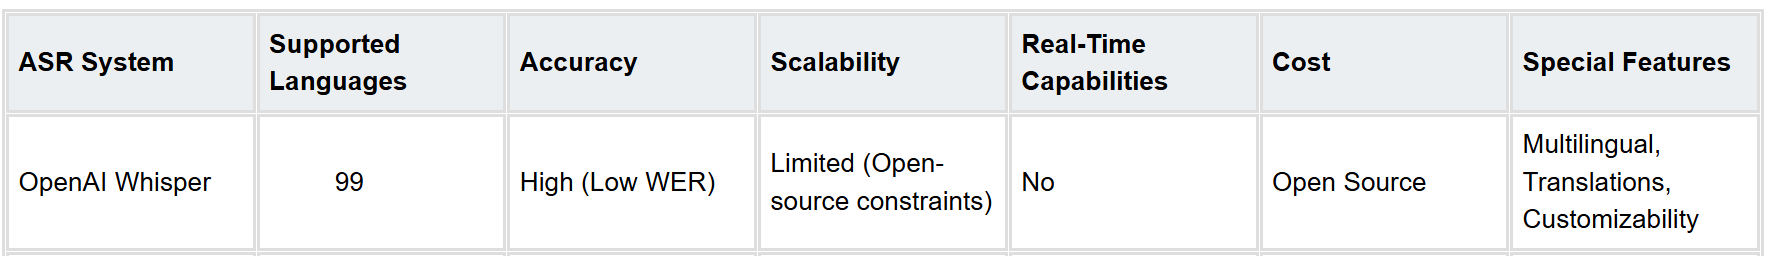

In [ ]:
Image(filename="/content/psiml-applied-ai/notebooks/attachments/Whisper-Summary.png", width=1600)

In [ ]:
from transformers.models.auto import AutoProcessor
from transformers import AutoModelForSpeechSeq2Seq, pipeline as hf_pipeline

whisper_path = "openai/whisper-small"
device = "cuda:0"
asr_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    whisper_path,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True,
    use_safetensors=True,
)
asr_model.to(device)
asr_processor = AutoProcessor.from_pretrained(whisper_path)

asr_pipe = hf_pipeline(
    task="automatic-speech-recognition",
    model=asr_model,
    tokenizer=asr_processor.tokenizer,
    feature_extractor=asr_processor.feature_extractor,
    device=0 if device == "cuda" else -1,
)

generate_kwargs = {"language": "sr", "task": "transcribe"}

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Let's test them on the several dataset samples:

In [ ]:
wav_path = f'/content/psiml-applied-ai/notebooks/wavs/audio_0.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


{'text': ' Očinioći su još uvijek na slobodi uprikos obinnoj istazi.'}

In [ ]:
wav_path = f'/content/psiml-applied-ai/notebooks/wavs/audio_1.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

{'text': ' I na kraju imamo zadatak da promjenimo ponashanje.'}

In [ ]:
wav_path = f'/content/psiml-applied-ai/notebooks/wavs/audio_2.wav'
asr_pipe(wav_path, generate_kwargs=generate_kwargs, return_timestamps=False)

{'text': ' Nema, izveš to ja o povredjenima.'}

## Neural Machine Translation with OPUS-MT

OPUS-MT is a family of Neural Machine Translation models for the efficient machine translation.
There is a model that translates Serbian to English - and we are using it below.

OPUS-MT Github: [`Helsinki-NLP/Opus-MT`](https://github.com/Helsinki-NLP/Opus-MT)

In [ ]:
from scripts.helpers import load_opus

opus_path = "Helsinki-NLP/opus-mt-tc-big-sh-en"
tok, mdl = load_opus(opus_path, device=device)
device = 'cuda'

def translate(text: str, max_new_tokens: int = 256, device: str = "cpu") -> str:
    inputs = tok(text, return_tensors="pt").to(device)
    with torch.inference_mode():
        out = mdl.generate(**inputs, max_new_tokens=max_new_tokens)
    return tok.batch_decode(out, skip_special_tokens=True)[0]

tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/849k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/794k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/474M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [ ]:
text_0 = "koji su bili glavni ospesi?"
translate(text_0, device=device)

'What were the main goals?'

In [ ]:
text_1 = "I na kraju imamo zadatak da promjenimo ponashanje."
translate(text_1, device=device)

'And in the end, we have the task of changing our behavior.'

In [ ]:
text_2 = "Nema, izveš to ja o povredjenima."
translate(text_2, device=device)

"No, I'll tell you about the injured."

## Voice Cloning + Text-to-Speech with Coqui XTTS v2

XTTS-v2 by Coqui AI is a voice generation model that lets you clone voices into a multitude of languages.

Because of the voice cloning part, it needs not only the translated text, but also the source WAV to retrieve audio features.

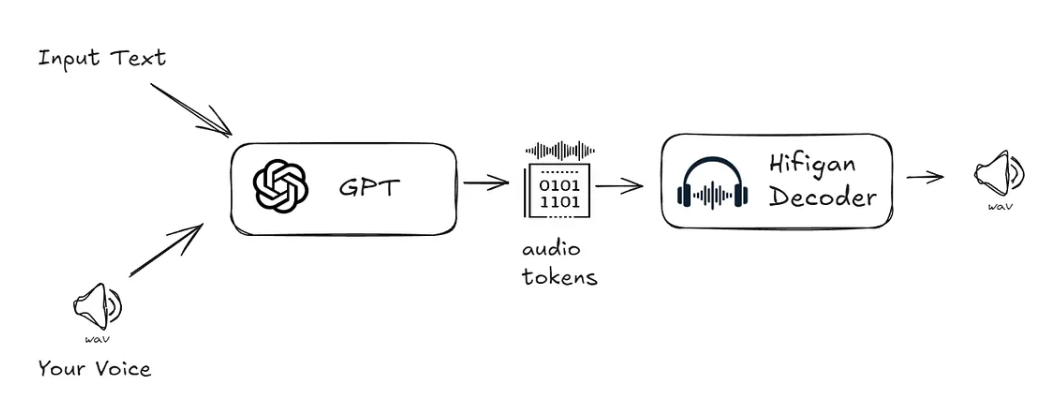

In [ ]:
Image(filename="/content/psiml-applied-ai/notebooks/attachments/Coqui-XTTS.png", width=1600)

In [ ]:
from IPython.display import display, Audio

def play_audio(path):
    display(Audio(path, autoplay=False))

# Paths + text
script = "/content/psiml-applied-ai/notebooks/scripts/xtts.py"
base = "/content/psiml-applied-ai/notebooks/wavs"
device = 'cuda'

speaker = f"{base}/audio_0.wav"
output  = f"{base}/audio_0_en.wav"
text    = "What were the main goals?"
lang    = "en"

# Generate
!python {script} "{speaker}" "{output}" "{text}" {lang} {device}

# Play result
play_audio(output)


/usr/local/miniconda/lib/python3.11/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
=== XTTS CLI ===
Speaker WAV: /content/psiml-applied-ai/notebooks/wavs/audio_0.wav
Output WAV: /content/psiml-applied-ai/notebooks/wavs/audio_0_en.wav
Text: What were the main goals?
Language: en
 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts
XTTS loaded!
 > Text splitted to sentences.
['What were the main goals?']
 > Processing time: 29.452815532684326
 > Real-time factor: 5.831010114348597
Saved: /content/psiml-applied-ai/notebooks/wavs/audio_0_en.wav


In [ ]:
speaker = f"{base}/audio_1.wav"
output  = f"{base}/audio_1_en.wav"
text    = "And in the end, we have the task of changing our behavior."

!python {script} "{speaker}" "{output}" "{text}" {lang} {device}

play_audio(output)


'wavs/audio_0_en.wav'

In [ ]:
speaker = f"{base}/audio_2.wav"
output  = f"{base}/audio_2_en.wav"
text    = "No, I'll tell you about the injured."

!python {script} "{speaker}" "{output}" "{text}" {lang} {device}

play_audio(output)


'wavs/audio_2_en.wav'

## Combining to the end-to-end Speech-to-Speech system


**Note:** the demo below works only from the local environment, and does not work from Google Colab.
The reason is that it needs to forward the localhost endpoint to access the Gradio UI.

In [ ]:
import os
import re
import tempfile
import librosa
import gradio as gr
import soundfile as sf
from IPython.display import display, Audio


def ensure_wav_16k_mono_safe(in_path: str) -> str:
    tmpdir = tempfile.mkdtemp(prefix="s2s_")
    base = os.path.basename(in_path)
    out_path = os.path.join(tmpdir, f"{os.path.splitext(base)[0]}_16k.wav")
    wav, sr = librosa.load(in_path, sr=16000, mono=True)
    sf.write(out_path, wav, 16000)
    return out_path


def _clean_path(p: str | None) -> str | None:
    if p is None:
        return None
    p = re.sub(r'[\x00\r\n]+', '', p).strip()
    return p or None


def resolve_output_path(user_out: str | None, default_fname: str = "xtts_en.wav") -> str:
    p = _clean_path(user_out)
    if not p:
        out_dir = tempfile.mkdtemp(prefix="s2s_")
        return os.path.join(out_dir, default_fname)
    p = os.path.expanduser(p)
    if p.endswith(os.sep) or os.path.isdir(p):
        os.makedirs(p, exist_ok=True)
        return os.path.join(p, default_fname)
    parent = os.path.dirname(p) or "."
    os.makedirs(parent, exist_ok=True)
    return p


def s2s_pipeline(input_audio, output_audio):
    import subprocess
    import shlex
    from pathlib import Path
    if not input_audio:
        return "No audio.", "", None

    # --- Normalize input ---
    in_path = input_audio if isinstance(input_audio, str) else input_audio.name
    norm_wav = ensure_wav_16k_mono_safe(in_path)

    # --- Speech → Text (ASR) ---
    asr_res = asr_pipe(norm_wav, generate_kwargs=generate_kwargs, return_timestamps=False)
    nmt_src_text = asr_res["text"].strip()

    # --- Translate Text ---
    nmt_trg_text = translate(nmt_src_text)

    # --- Resolve output path ---
    out_wav = resolve_output_path(output_audio)

    # --- Build XTTS.py command ---
    xtts_script = "/content/psiml-applied-ai/notebooks/scripts/xtts.py"

    cmd = f'python {xtts_script} "{norm_wav}" "{out_wav}" "{nmt_trg_text}" en'

    # --- Run TTS externally ---
    print("Running XTTS synthesis...")
    subprocess.run(shlex.split(cmd), check=True)

    # --- Verify output ---
    if not Path(out_wav).exists():
        raise RuntimeError("XTTS failed to generate output audio.")

    return nmt_src_text, nmt_trg_text, out_wav

In [ ]:
import gradio as gr
with gr.Blocks(title="Speech→Speech: Serbian → English") as demo:
    gr.Markdown(
        "## 🎤 Serbian → English (Whisper + OPUS-MT + XTTS v2)\n"
        "Upload or record Serbian speech → ASR (sr) → NMT (sr→en) → TTS (English, cloned voice)."
    )

    with gr.Row():
        audio_in = gr.Audio(
            sources=["upload", "microphone"],
            type="filepath",
            label="Input audio (Serbian, WAV recommended)"
        )
        out_path = gr.Textbox(
            value="",
            placeholder="(optional) /path/to/output.wav or a directory",
            label="Output WAV path (optional)"
        )

    run_btn = gr.Button("Translate & Speak")

    with gr.Row():
        asr_out = gr.Textbox(label="ASR (Serbian text)")
        nmt_out = gr.Textbox(label="NMT (English text)")
    audio_out = gr.Audio(label="Synthesized English (cloned voice)")

    run_btn.click(
        fn=s2s_pipeline,
        inputs=[audio_in, out_path],
        outputs=[asr_out, nmt_out, audio_out]
    )
demo.queue()
demo.launch(share=True, debug=False, inline=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7d6a58f3090cb71138.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Running XTTS synthesis...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7863 <> https://7d6a58f3090cb71138.gradio.live


## Note: Omni-modal models

**Idea**: if the model is able to process ASR, translation and TTS itself, that can be promising from the quality standpoint compared to the pipeline with 3 independent parts.

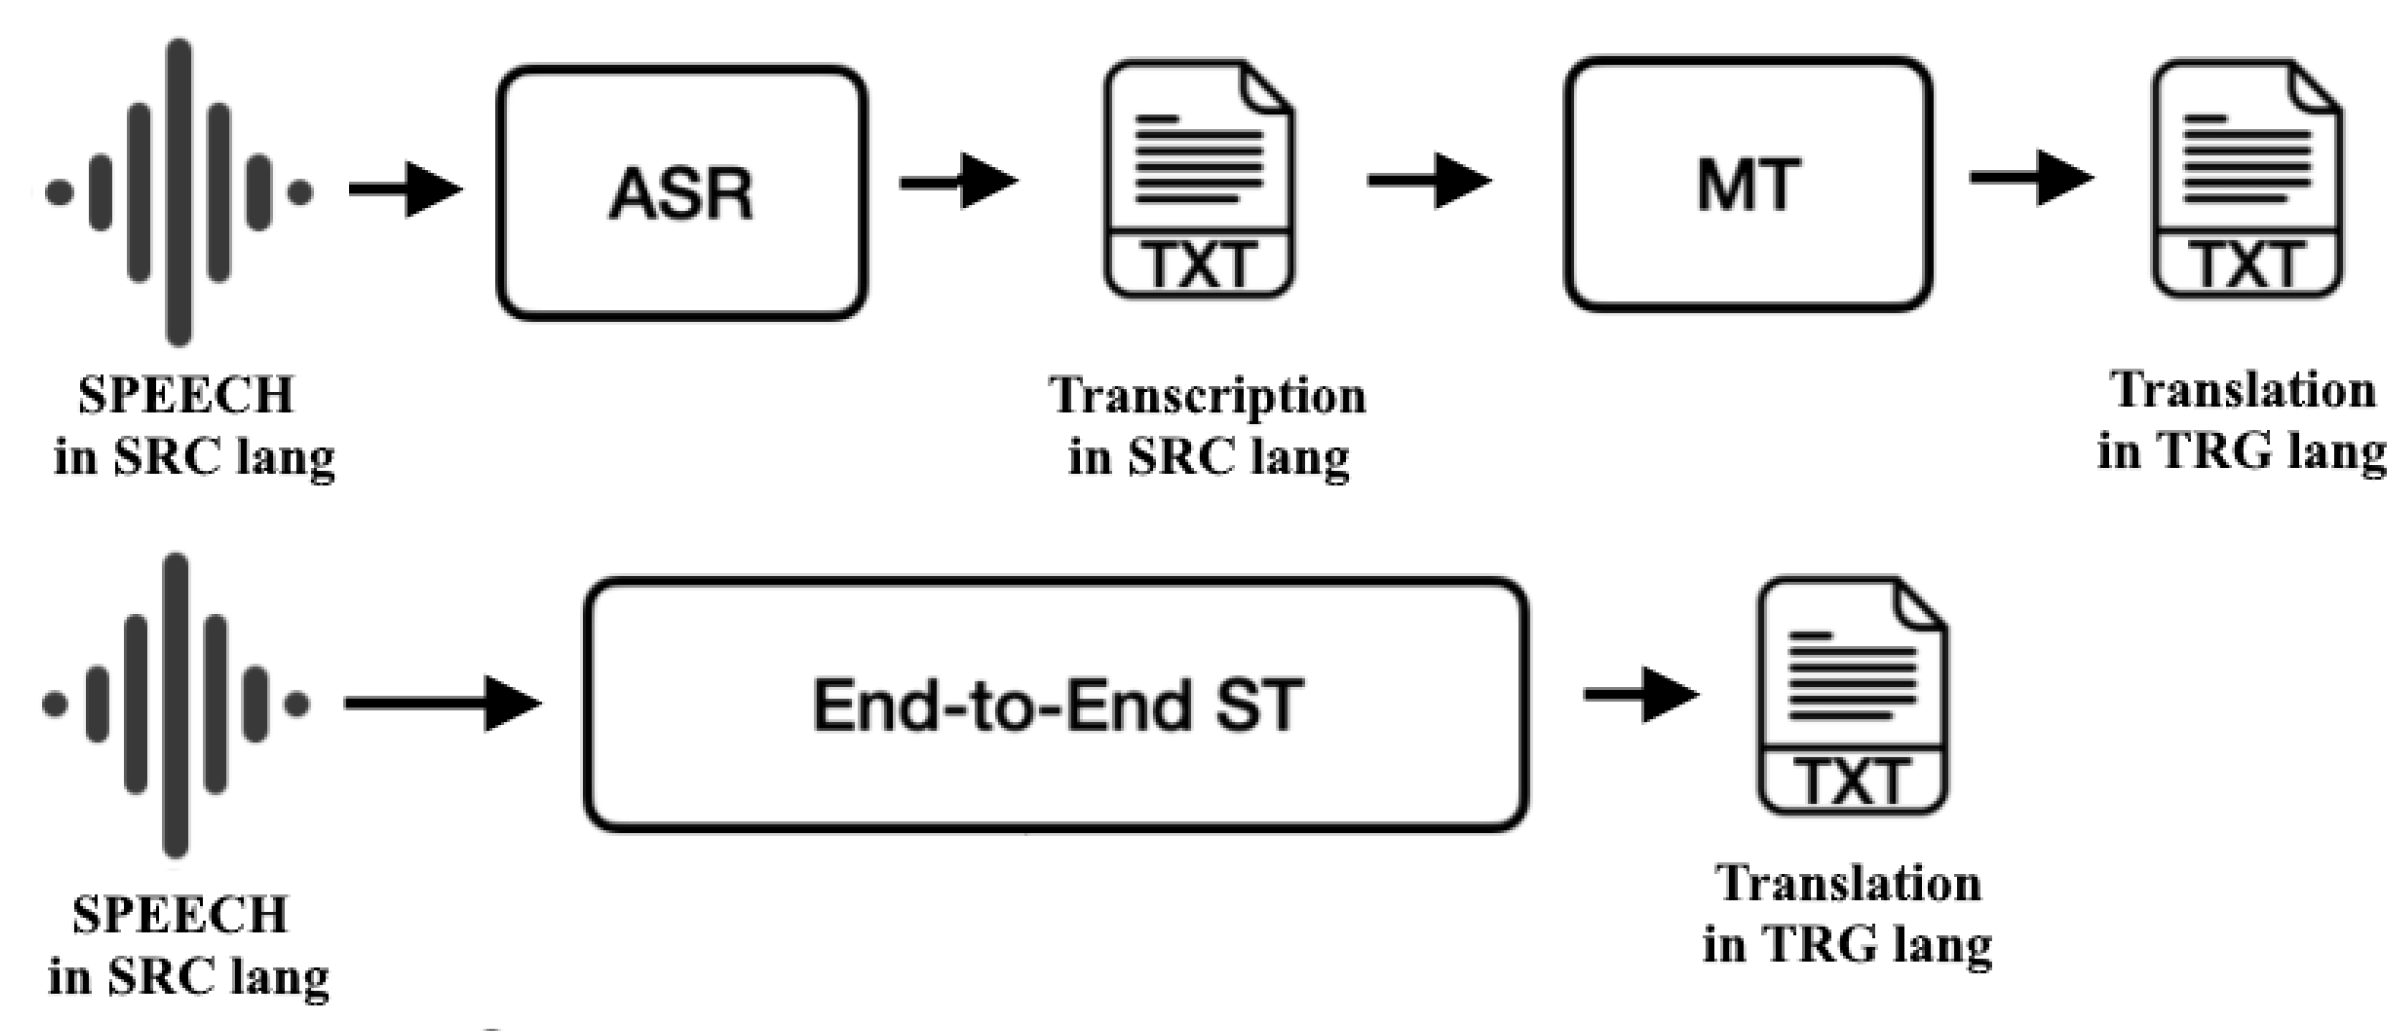